# Part 2: MLP

In this part of the assignment, you will complete a Do-It-Yourself (DIY) implementation of a multilayer perceptron (MLP), including code to optimize the network with backpropagation and minibatch stochastic gradient descent, that corresponds to the Scikit-Learn API.

**Learning objectives.** You will:
1. Write object-oriented code for a neural network class in Python, matching standard API patterns.
2. Apply numerical Python (NumPy) to efficiently implement a multilayer perceptron with backpropagation and minibatch stochastic gradient descent. 
3. Evaluate your implementation compared to the Scikit-Learn standard on real image data.

The following code imports a dataset consisting of 8 by 8 pixel grayscale images of handwritten digits. Some images are visualized and then the data are flattened into 64-value one-dimensional NumPy arrays before splitting into training and testing sets.

Dataset shape: (1797, 64)
Number of classes: 10
Training set size: 1257
Test set size: 540


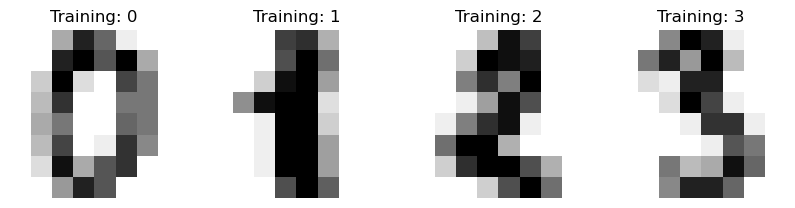

In [4]:
# Run but DO NOT MODIFY this code

from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

digits = load_digits()
print(f"Dataset shape: {digits.data.shape}")
print(f"Number of classes: {len(np.unique(digits.target))}")

# visualizing examples
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Split data into 70% train and 30% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.3, shuffle=False
    )

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

## Task 1

Using Scikit-Learn, build and train a [multilayer perceptron classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) fitted on the training data with one hidden layer to predict the value of `y` given `X`. 

**Configuration guidance:**
- Use `hidden_layer_sizes` between (50,) and (200,). Start with (100,) as a baseline.
- Set `max_iter=500` to allow sufficient training time
- Use `random_state=2025` for reproducibility

Ensure that you achieve a **training** [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of at least 90%.   

Then evaluate and report the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of your model on the **test** data.

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
# Write code for task 1 here

MLP_model = MLPClassifier(hidden_layer_sizes = (100,), max_iter = 500, random_state = 2025)
MLP_model.fit(X_train, y_train)
y_prediction_train = MLP_model.predict(X_train)
y_prediction_test = MLP_model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_prediction_train)
test_accuracy = accuracy_score(y_test, y_prediction_test)
print("The training accuracy is", train_accuracy)
print("The test accuracy is", test_accuracy)

The training accuracy is 1.0
The test accuracy is 0.9333333333333333


## Mathematical Background for DIY Implementation

For your DIY implementation, you will build a neural network with the following architecture:
- **Input layer**: 64 features (flattened 8×8 images)
- **Hidden layer**: Variable size with ReLU activation function
- **Output layer**: 10 units (one per digit class) with softmax activation
- **Loss function**: Cross-entropy loss

The key equations for forward and backward propagation in the network are derived below for your convenience during implementation.

### Key Equations
**Notation**
- `X`: Input design matrix
- `W1`: (in_size, h_size) matrix of model parameters between input and hidden units
- `z1`: pre-activation for hidden units
- `a1`: post-activation for hidden units
- `W2` (h_size, out_size) matrix of model parameters between hidden and output units
- `z2` unnormalized output values
- `y_pred` normalized output values: Probability distribution over classes
- `y_onehot` One-hot encoding of true class membership label

**Forward Pass:**
1. Hidden layer: `z1 = X @ W1`, `a1 = relu(z1)` (computing the nonlinear activation of each unit)
2. Output layer: `z2 = a1 @ W2`, `y_pred = softmax(z2, axis=1)` (apply softmax to each row)

**Loss Function:**
- Average cross-entropy: `L = -np.sum(y_onehot * np.log(y_pred + 1e-15)) / len(y_onehot)` where `y` is one-hot encoded and adding `1e-15` (or $10^{-15}$) is for numerical stability to prevent taking the logarithm of 0.

**Backward Pass (Gradients):** The derivatives of the loss with respect to model parameters are:
1. Output layer gradient: `dW2 = a1.T @ (y_pred - y_onehot)`
2. Hidden layer gradient: `dW1 = X.T @ ((y_pred - y_onehot) @ W2.T * (z1 > 0))`

(Note that `.T` is the transpose of a matrix and `(z1 > 0)` is the derivative of ReLU function ).

## Task 2

Implement a do it yourself (DIY) multilayer perceptron classifier following the Scikit-Learn API by completing the `NeuralNet` class below. **You may not use `sklearn` for this task -- the point is for you to implement your own multilayer perceptron.**

**Architecture specifications:**
- Single hidden layer with ReLU activation
- Output layer with softmax activation for multiclass classification
- Cross-entropy loss function
- Minibatch stochastic gradient descent optimization

**Implementation tips and notes:**

  - **Data format**: The Scikit-Learn API treats an input `X` array as a matrix with a row for every data point and a column for every feature.

  - **One-hot encoding targets**: Convert integer labels (`y`) to one-hot vectors for cross-entropy loss. For example, the label `3` becomes `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]` - a vector with 1 at position 3 and 0s elsewhere. The `to_onehot` method is implemented for you.

  - **Initialization**: Note that (slightly deviating from the `sklearn` API for specificity) the `init` method (the constructor) has two mandatory parameters to specify the input size (number of features) and output size (number of classes). This allows you to initialize the model weights as instance variables in the `init` method. This is already done for you.

  - **Forward Passes and Predictions**: The three methods `forward`, `predict_proba`, and `predict` are all very related and should be implemented in this order, with each subsequent method calling the previous. Note that `forward` should return all intermediate calculations (these will be needed by `backward`). `predict_proba` returns a 2D array (row per input data point / row in `X`, column per class) whereas `predict` only returns a 1D array with a class prediction for each data point / row in `X`.

  - **Backprop and Training**: The `backward` method computes derivatives of the loss with respect to model parameters `W1` and `W2` given input data `X` with predictive targets in one-hot encoding `y_onehot` and all of the information returned by the `forward` method. The `fit` method should optimize model parameters `W1` and `W2` using minibatch SGD as outlined. Update the model weights stored as instance variables. Keep track of evaluation information such as the average training loss or the training accuracy to print per epoch when `verbose=True`.
   
  - **Vectorization**: Use vectorized NumPy operations for efficiency. Avoid loops over large datasets.

In [9]:
# Write code for task 2 here

# You can use the scipy implementation of softmax
from scipy.special import softmax

# You can use the numpy argmax and maximum functions
from numpy import argmax, maximum

class NeuralNet:
    """
    MLP for multiclass classification with:
    - Single hidden layer with ReLU activation
    - Output layer with softmax activation
    - Cross-entropy loss function
    - Minibatch SGD optimization
    """
    def __init__(self, in_size, out_size, 
                 h_size=100, lr=0.001, batch_size=32,
                 epochs=10, random_state=2025):
        """
        Initialize the neural network.
        
        Parameters:
        - in_size: number of input features
        - out_size: number of output classes
        - h_size: number of hidden units
        - lr: learning rate
        - batch_size: minibatch size
        - epochs: number of training epochs
        - random_state: random seed
        """
        self.in_size = in_size
        self.out_size = out_size
        self.h_size = h_size
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        np.random.seed(random_state)
        self.W1 = np.random.normal(0, 0.1, size=(in_size, h_size))
        self.W2 = np.random.normal(0, 0.1, size=(h_size, out_size))
    
    def to_onehot(self, y):
        """Convert integer labels to one-hot encoding"""
        return np.eye(self.out_size)[y]
    
    def relu(self, z):
        """Compute ReLU activation"""
        return np.maximum(0, z)
    
    def softmax(self, z):
        """Softmax normalization applied per row"""
        return softmax(z, axis=1)
    
    def shuffle_data(self, X, y_onehot):
        """Shuffle training data and labels together"""
        indices = np.random.permutation(len(X))
        return X[indices], y_onehot[indices]

    def get_batch(self, X, y_onehot, start_idx, batch_size):
        """Get a minibatch of data starting at start_idx"""
        end_idx = min(start_idx + batch_size, len(X))
        return X[start_idx:end_idx], y_onehot[start_idx:end_idx]
    
    # YOUR TODOS BEGIN BELOW THIS POINT

    def forward(self, X):
        """Forward pass returning intermediate values for backprop"""
        # TODO: Implement forward pass
        # Hint: Use the forward equations derived above
        # Return z1, a1, z2, y_pred
        z1 = X @ self.W1
        a1 = self.relu(z1)
        z2 = a1 @ self.W2
        y_pred = self.softmax(z2)
        return z1, a1, z2, y_pred

    def predict_proba(self, X):
        """Predict probabilities for each row in X for each class"""
        # TODO: Implement predict_proba
        # Hint: Use the forward method
        z1, a1, z2, y_pred = self.forward(X)
        return y_pred

    def predict(self, X):
        """Predict class for each row in X"""
        # TODO: Use predict_proba and return class with highest probability
        # Hint: Use numpy's argmax function
        probabilities = self.predict_proba(X)
        results = np.argmax(probabilities, axis = 1)
        return results
     
    def backward(self, X, y_onehot, z1, a1, z2, y_pred):
        """Compute gradients using backpropagation"""
        # TODO: Implement backward pass
        # Hint: Use the backprop equations derived above
        # Return dW1, dW2
        dW2 = a1.T @ (y_pred - y_onehot)
        dW1 = X.T @ ((y_pred - y_onehot) @ self.W2.T * (z1 > 0))
        return dW1, dW2
     
    def fit(self, X, y, verbose=False):
        """Train on inputs X with labels y using backprop and minibatch SGD"""
        # TODO: Complete fit implementation
        # Convert y to one-hot encoding
        # Training loop over epochs
        #   - Shuffle data
        #   - Loop over minibatches
        #     - forward pass
        #     - backward pass
        #     - update weights
        #   - Print progress (training loss and/or accuracy) if verbose
        y_onehot_encoding = self.to_onehot(y)
        for epoch in range(self.epochs):
            X_shuffle, y_shuffle = self.shuffle_data(X, y_onehot_encoding)
            for start_idx in range(0, len(X_shuffle), self.batch_size):
                X_batch, y_batch = self.get_batch(X_shuffle, y_shuffle, start_idx, self.batch_size)
                z1, a1, z2, y_pred = self.forward(X_batch)
                dW1, dW2 = self.backward(X_batch, y_batch, z1, a1, z2, y_pred)
                self.W1 -= self.lr * dW1
                self.W2 -= self.lr * dW2
            if verbose:
                full_z1, full_a1, full_z2, full_y_pred = self.forward(X)
                L = -np.sum(y_onehot_encoding * np.log(full_y_pred + 1e-15)) / len(y_onehot_encoding)
                accuracy = (np.argmax(full_y_pred, axis = 1) == y).mean()
                print("Epoch", epoch + 1, ": Loss =", L, ", Accuracy =", accuracy)

## Task 3

Show that your `NeuralNet` class can effectively learn. Fit an instance of your DIY model on the training data to predict the value of `y` given `X`. 

**Hyperparameter guidance:** While you can choose your own hyperparameters and experiment as you see fit, we recommend the following as reasonable starting points:
- Start with `h_size` around `100` to `500` for the hidden layer
- Use a learning rate `lr` between `0.005` and `0.01` for your learning rate
- Use a `batch_size` of 16 to 64 for stable training
- Begin with `epochs=100` and adjust based on convergence
- Set `verbose=True` to monitor training progress (you should see loss decreasing over epochs and accuracy increasing)

Ensure that you achieve a **training** [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of at least 80% (your implementation may not match scikit-learn's optimized performance, but should demonstrate competitive functionality).   

Then evaluate and report the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) of your model on the **test** data.

In [11]:
# Write code for task 3 here

neuralnet_model = NeuralNet(in_size = 64, out_size = 10, h_size = 100, lr = 0.005, batch_size = 16, epochs = 100)
neuralnet_model.fit(X_train, y_train, verbose = True)
y_prediction_train_neuralnet = neuralnet_model.predict(X_train)
y_prediction_test_neuralnet = neuralnet_model.predict(X_test)
neuralnet_train_accuracy = accuracy_score(y_train, y_prediction_train_neuralnet)
neural_test_accuracy = accuracy_score(y_test, y_prediction_test_neuralnet)
print("The training accuracy is", neuralnet_train_accuracy)
print("The test accuracy is", neural_test_accuracy)
print("The training accuracy from Task 1 is", train_accuracy)
print("The test accuracy from Task 1 is", test_accuracy)

Epoch 1 : Loss = 0.8763122991859336 , Accuracy = 0.7064439140811456
Epoch 2 : Loss = 0.3034165046301553 , Accuracy = 0.888623707239459
Epoch 3 : Loss = 0.3853998914720612 , Accuracy = 0.8846459824980112
Epoch 4 : Loss = 0.21104494618364134 , Accuracy = 0.9443118536197295
Epoch 5 : Loss = 0.14184336840717657 , Accuracy = 0.9681782020684169
Epoch 6 : Loss = 0.08718757306743806 , Accuracy = 0.9824980111376292
Epoch 7 : Loss = 0.03352708876662646 , Accuracy = 0.9888623707239459
Epoch 8 : Loss = 0.15222353690720897 , Accuracy = 0.9554494828957836
Epoch 9 : Loss = 0.06826868234108611 , Accuracy = 0.9745425616547335
Epoch 10 : Loss = 0.23096585101052966 , Accuracy = 0.9355608591885441
Epoch 11 : Loss = 0.017640517167690252 , Accuracy = 0.9936356404136834
Epoch 12 : Loss = 0.024294345976962697 , Accuracy = 0.9920445505171042
Epoch 13 : Loss = 0.03789438001355667 , Accuracy = 0.9856801909307876
Epoch 14 : Loss = 0.015473551450653381 , Accuracy = 0.9952267303102625
Epoch 15 : Loss = 0.0085711181

## Task 4: Hyperparameter Ablation Study

Understanding how hyperparameters affect model performance is crucial for training effective neural networks. In this task, you will systematically test different learning rates and batch sizes to observe their impact on training convergence.

**What you'll investigate:** You will test whether different hyperparameter combinations can achieve good performance (>80% training accuracy) and how quickly they converge to this threshold.

1. Test different learning rates using your `NeuralNet` class. Leave all other hyperparameters at their default values, varying only the learning rate `lr`.
    - Learning rates to test: `[0.0001, 0.001, 0.01]`
    - Set `verbose=True` to monitor training progress

2. Test different batch sizes using your `NeuralNet` class. Leave all other hyperparameters at their default values, varying only the batch size `batch_size`.
    - Batch sizes to test: `[16, 128, 1024]`
    - Set `verbose=True` to monitor training progress

3. Record your results in the table format below. For each hyperparameter setting, note how many epochs were needed to reach >80% training accuracy. For example, if the network achieves >80% accuracy after the first epoch, write 1 in table. If after second epoch the accuracy >80%, write 2. If a given setting failed to reach that accuracy in the default maximum number of epochs, you can just write N/A.

In [13]:
# Write code for experimenting in task 4 here
# Your ablation study does not have to be automated,
# it is fine to run this cell multiple times and just
# record your results below.

learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [16, 128, 1024]
for lr in learning_rates:
    print("Model with", lr, "as the learning rate and default batch size.")
    model = NeuralNet(in_size = 64, out_size = 10, lr = lr)
    model.fit(X_train, y_train, verbose = True)
    print()
for bs in batch_sizes:
    print("Model with default learning rate and", bs, "as the batch size.")
    model = NeuralNet(in_size = 64, out_size = 10, batch_size = bs)
    model.fit(X_train, y_train, verbose = True)
    print()

Model with 0.0001 as the learning rate and default batch size.
Epoch 1 : Loss = 0.9756647362501694 , Accuracy = 0.6945107398568019
Epoch 2 : Loss = 0.5506590100288823 , Accuracy = 0.8424821002386634
Epoch 3 : Loss = 0.38689279027840706 , Accuracy = 0.8846459824980112
Epoch 4 : Loss = 0.3045097256437147 , Accuracy = 0.9220365950676214
Epoch 5 : Loss = 0.2558975287647104 , Accuracy = 0.939538583929992
Epoch 6 : Loss = 0.21771988687374022 , Accuracy = 0.9498806682577565
Epoch 7 : Loss = 0.1908185162085133 , Accuracy = 0.9562450278440732
Epoch 8 : Loss = 0.17560785157225672 , Accuracy = 0.9594272076372315
Epoch 9 : Loss = 0.1570988682154445 , Accuracy = 0.9665871121718377
Epoch 10 : Loss = 0.14492625461482714 , Accuracy = 0.964200477326969

Model with 0.001 as the learning rate and default batch size.
Epoch 1 : Loss = 0.30012486018799567 , Accuracy = 0.9053301511535402
Epoch 2 : Loss = 0.12621570080263425 , Accuracy = 0.9737470167064439
Epoch 3 : Loss = 0.1045047223862448 , Accuracy = 0.96

TODO: Fill in your experimental results for task 4 here

| Learning Rate | Batch Size  | Epochs to reach >80% accuracy  |
|---------------|-------------|--------------------------------|
| 0.0001        | [default]   |         2        |
| 0.001         | [default]   |         1        |
| 0.01          | [default]   |         N/A        |
| [default]     | 16          |         1        |
| [default]     | 128         |         3        |
| [default]     | 1024        |         N/A        |